# Rabi_from_nonunitary_kicks
A single-script repo with a few-line example showing that a coherent quantum evolution can be synthesized by nonunitary fluctuations.

This is a simple example showing that a coherent Rabi oscillation can be generated by the stochastic
application of the Kraus operators 

$K_{\pm} = 1/\sqrt{2} (1 \mp \Gamma \sigma_{\pm} dt)$ (nonunitaries)

where $\sigma_{\pm}$ is the lowering and higher operators of a two-level quantum system.

The code takes a pure state $|\psi\rangle$
and evolves it as

$|\psi (t+dt)\rangle = K_t |\psi(t)\rangle/ || K_t |\psi(t)\rangle||$

in density matrix form, this reads

$\rho(t+dt) =  K_t  \rho(t) K_t^{\dagger} / Tr (K_t  \rho(t) K_t^{\dagger}) $

The state is at all times pure, and it corresponds to the realization of a single quantum trajectory.

Operators $K_t$ is sampled from $(K_+,K_-)$ with probabilities 
$p_{\pm} = \langle \psi(t) |K_{\pm}^{\dagger} K_{\pm} |\psi(t)\rangle$.
As $dt\rightarrow 0$, the single stochastic nonunitary trajectory becomes deterministic and unitary.
The equation of motion emerging is the Schrodinger equation:

$\partial_t |\psi\rangle = -i(\Gamma/2)\sigma_y |\psi\rangle.$

or identically for the density matrix

$\partial_t \rho = -i \Gamma/2 [\sigma_y,\rho].$

# Import necesesary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define parameters to make figures beautiful

In [2]:
# Set font and sizes for figures (ignore, plotting functions)

fontsize = 7
fontsize_tick = 7
linewidth = 0.5
spinewidth = 0.5 #0.8
pad = 1
tick_size = 2.0
mpl.rcParams['savefig.transparent'] = True
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.linewidth'] = spinewidth
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['axes.labelpad'] = pad

mpl.rcParams['xtick.major.size'] = tick_size
mpl.rcParams['ytick.major.size'] = tick_size
mpl.rcParams['xtick.minor.size'] = tick_size / 2.0
mpl.rcParams['ytick.minor.size'] = tick_size / 2.0
mpl.rcParams['xtick.major.width'] = spinewidth
mpl.rcParams['xtick.minor.width'] = spinewidth / 2.0
mpl.rcParams['ytick.major.width'] = spinewidth
mpl.rcParams['ytick.minor.width'] = spinewidth / 2.0
mpl.rcParams['xtick.major.pad']= pad #4
mpl.rcParams['ytick.major.pad']= pad #4
mpl.rcParams['xtick.minor.pad']= pad / 2.0 #4
mpl.rcParams['ytick.minor.pad']= pad / 2.0 #4
mpl.rcParams['xtick.labelsize'] = fontsize_tick
mpl.rcParams['ytick.labelsize'] = fontsize_tick

mpl.rcParams['legend.fontsize'] = fontsize_tick
mpl.rcParams['legend.frameon'] = True

# Here we define a Hilbert space of dimesnion two and the Pauli matrices.

In [3]:
dim = 2
Gamma = 2*np.pi # define numerical rate


I = np.matrix([ [1, 0],
                [0,1] ]) #define the identity

sp = np.matrix([ [0, 1],
                 [0,0] ]) #sigma_+ matrix

sm = np.matrix([ [0, 0],
                 [1,0] ])    #sigma_- matrix

sx = np.matrix([ [0, 1],
                 [1,0] ]) #sigma_x matrix

sy = np.matrix([ [0, -1j],
                 [1j,0] ]) #sigma_y matrix

sz = np.matrix([ [1, 0],
                 [0,-1] ]) #sigma_z matrix

# Here we define a helper function that creates trajectiries

In [4]:
def A_stochastic_diff_step(rho, Kraus_map):
    Proba_weights = []
    for K in Kraus_map:
        K_dag =np.conj(K).T
        Proba_weights.append(np.real(np.trace(K @ rho @ K_dag)))
    Proba_weights = Proba_weights/np.sum(Proba_weights)

    choice = np.random.choice(range(len(Kraus_map)), p = Proba_weights)
    
    chosen_K =  Kraus_map[choice]
    chosen_K_dag = np.conj(chosen_K).T
    rho_new = chosen_K @ rho @ chosen_K_dag

    return rho_new / np.trace(rho_new)

def diff_Kraus_element(dt, mu):
    return np.sqrt(0.5) * (I +  dt * mu)

def Kraus_map_gen(dt, mus):
    return [ diff_Kraus_element(dt, mu) for mu in mus]

def trajectory_spin(rho_initial, Kraus_map, dt, T_tot = 1):

    steps = int(T_tot/dt)

    rho_t = [rho_initial] #Array to contain the state at all times
    sigma_x_array = [np.real(np.trace((rho_initial @ sx)))]  #Array to contain the mean value of sigma_x at each times
    sigma_y_array = [np.real(np.trace((rho_initial @ sy)))]  #Array to contain the mean value of sigma_y at each times
    sigma_z_array = [np.real(np.trace((rho_initial @ sz)))]  #Array to contain the mean value of sigma_z at each times

    for i in range(steps):
        rho_t.append(A_stochastic_diff_step(rho_t[-1],Kraus_map))
        sigma_x_array.append(np.real(np.trace((rho_t[-1] @ sx)))) #Store result for obserbable
        sigma_y_array.append(np.real(np.trace((rho_t[-1] @ sy)))) #Store result for obserbable
        sigma_z_array.append(np.real(np.trace((rho_t[-1] @ sz)))) #Store result for obserbable
    
    return np.array(sigma_x_array), np.array(sigma_y_array), np.array(sigma_z_array)

# Numerical experiment: Emergence of Rabi oscillation from nonunitary random kicks

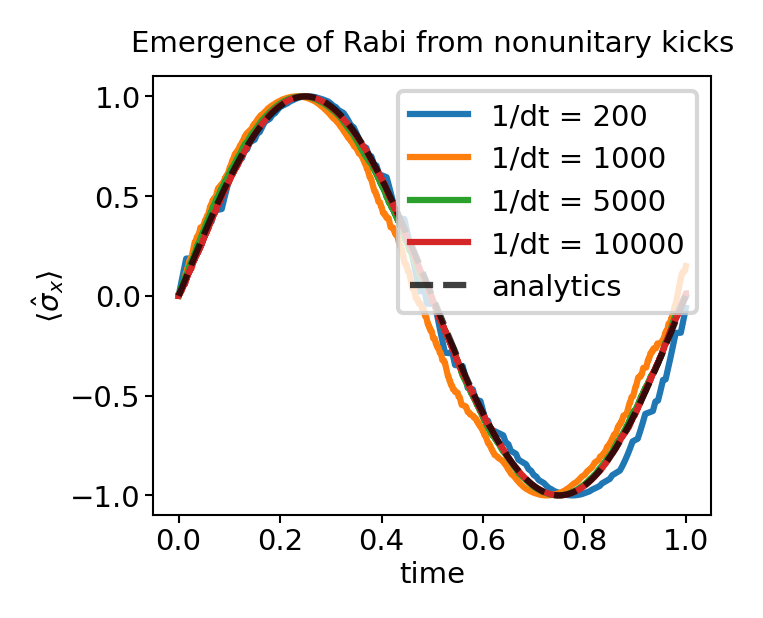

In [5]:

fig, axes = plt.subplots(1, 1, figsize=(2.4,1.9),dpi=300)

alpha = 1 # 1/np.sqrt(2) #define initial (pure) state as \alpha |0> + \beta |1>
beta = np.sqrt(1 - alpha**2) * np.exp(-1j*np.pi/8)

psi_0 = alpha * np.matrix([1,0]) + beta * np.matrix([0,1]) #build initial state.
rho_0 = np.kron(np.transpose(np.conj(psi_0)),psi_0) #define associated density matrix to initial state. Projector.


mus = [-Gamma * sp , Gamma * sm]


for dt in [1/200,1/1000,1/5000,1/10000]: #run simulation for diferent time meshings finess
    times = np.linspace(0,1,int(1/dt)+1)
    Kraus_map = Kraus_map_gen(dt, mus)
    sigma_x_array, sigma_y_array, sigma_z_array = trajectory_spin(rho_0, Kraus_map, dt, T_tot = 1)

    plt.plot(times,sigma_x_array,label = '1/dt = %.i' %(1/dt))
    
plt.xlabel('time')
plt.ylabel(r'$\langle \hat \sigma_x\rangle$')
plt.title('Emergence of Rabi from nonunitary kicks')
plt.plot(times,np.sin(times * Gamma),'--k', alpha = 0.75,label = 'analytics')

plt.legend()



# The evolution preserves purity $ Tr [\rho^2] = 1/2 (1 + |\vec p|^2) $
# where $\rho = 1/2(1+ \vec p \cdot\vec{\hat{\sigma}}  )$
# and
# $\vec p = (\sum p_n \vec p_n)$


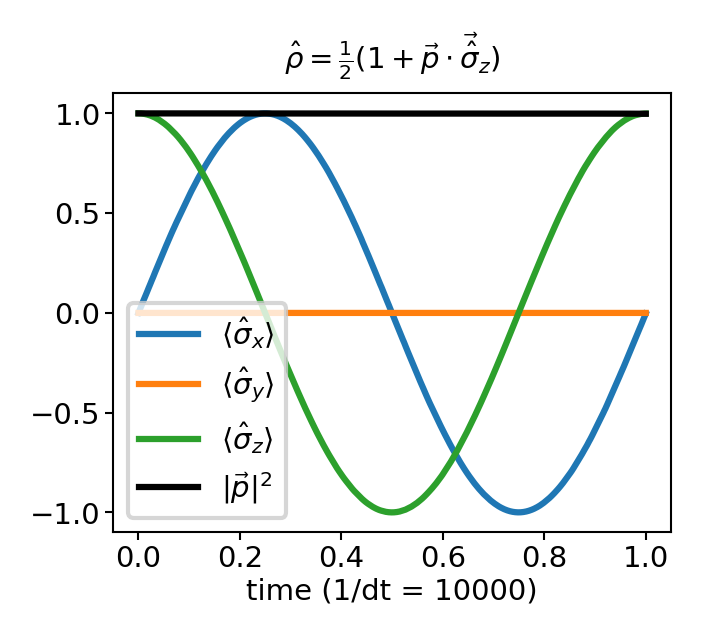

In [6]:
dt = 1/10000

times = np.linspace(0,1,int(1/dt)+1)
Kraus_map = Kraus_map_gen(dt, mus)



N_traj = 50

sigma_x_array, sigma_y_array, sigma_z_array = trajectory_spin(rho_0, Kraus_map, dt, T_tot = 1)

sigma_x_array = sigma_x_array/N_traj
sigma_y_array = sigma_y_array/N_traj
sigma_z_array = sigma_z_array/N_traj

for traj_n in range(N_traj - 1): #ensemble average
    sigma_x_array_temp, sigma_y_array_temp, sigma_z_array_temp = trajectory_spin(rho_0, Kraus_map, dt, T_tot = 1)

    sigma_x_array += sigma_x_array_temp/N_traj
    sigma_y_array += sigma_y_array_temp/N_traj
    sigma_z_array += sigma_z_array_temp/N_traj

fig, axes = plt.subplots(1, 1, figsize=(2.4,1.9),dpi=300)
plt.plot(times,sigma_x_array,label = r'$\langle \hat \sigma_x\rangle$')
plt.plot(times,sigma_y_array,label = r'$\langle \hat \sigma_y\rangle$')
plt.plot(times,sigma_z_array,label = r'$\langle \hat \sigma_z\rangle$')

norm2_of_Bloch_vector = sigma_x_array**2 + sigma_y_array**2 + sigma_z_array**2
plt.plot(times,norm2_of_Bloch_vector,'k',label = r'$|\vec p|^2 $')
plt.xlabel('time (1/dt = %.i)' %(1/dt))

plt.title(r'$\hat \rho = \frac{1}{2}(1+\vec p \cdot\vec\hat \sigma_z)$')
plt.legend()